<a href="https://colab.research.google.com/github/RonBartov/Image_Reconstruction_Unet_Architecture/blob/main/Image_Reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**The Unet Architecture**

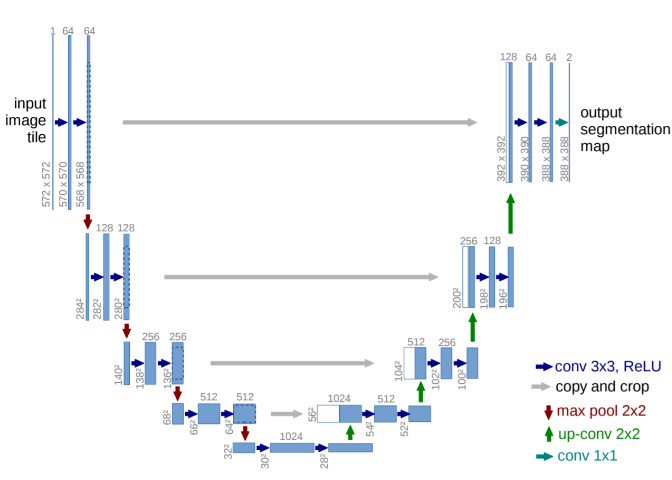

In [27]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Implementing the main blocks**

In [5]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

##**Testing the Blocks**

In [24]:
enc_block = Block(1, 64)
x = torch.randn(1, 1, 572, 572) # the dimentions are just for testing
enc_block(x).shape

torch.Size([1, 64, 568, 568])

##**Implementing the Encoder**

when calling forward we are apllying blocks-->maxpool-->blocks and so on

forwad returns features list

Here, we are defining the input size to be (3,572,572)

In [22]:
class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

##**Testing the Encoder**

In [23]:
encoder = Encoder()
# input image
x = torch.randn(1, 3, 572, 572)
ftrs = encoder(x)
for ftr in ftrs: print(ftr.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


##**Implementing the Decoder**

In [12]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

##**Testing the Decoder**

In [13]:
decoder = Decoder()
x = torch.randn(1, 1024, 28, 28)
decoder(x, ftrs[::-1][1:]).shape

torch.Size([1, 64, 388, 388])

##**Create the Unet**

In [16]:
class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

##**Testing Unet**

In [25]:
unet = UNet()
x = torch.randn(1, 3, 572, 572)
unet(x).shape

torch.Size([1, 1, 388, 388])

##**Import data**

In [52]:
TrainFilePath = '/content/drive/MyDrive/Projects/Cancer Scan Image Reconstruction/Example Data Set/train_point_clouds.h5'
FullDataFilePath = '/content/drive/MyDrive/Projects/Cancer Scan Image Reconstruction/Example Data Set/full_dataset_vectors.h5'
TestFilePath = '/content/drive/MyDrive/Projects/Cancer Scan Image Reconstruction/Example Data Set/test_point_clouds.h5'

In [54]:
# Train and Test
with h5py.File(FullDataFilePath, "r") as hf_full:    
     X_train = hf_full["X_train"][:]
     y_train = hf_full["y_train"][:]    
     X_test = hf_full["X_test"][:]  
     y_test = hf_full["y_test"][:]

In [51]:
with h5py.File(TestFilePath, "r") as hf:    
    a = hf["0"]
    b = hf["1"]    
    digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
    digit_b = (b["img"][:], b["points"][:], b.attrs["label"]) 